### About
### Build an object detection model to detect ships in ports using satellite imagery.

### Import neccessary packages and libaries.

In [3]:
import pandas as pd #dataframe manipulation
import numpy as np  #for numerical process
import seaborn as sns #for visualization
from matplotlib import pyplot as plt #for visualization
from PIL import Image, ImageDraw #for read the image
Image.MAX_IMAGE_PIXELS = None
import skimage.color 
import skimage.util
import imagehash #for calculation hash value of image
import cv2 #for read the image
import os
import re
import requests
import itertools
#import distance
import time
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import wandb
import json

from sklearn.model_selection import train_test_split,KFold,GroupKFold

import tqdm
from tqdm.notebook import  tqdm_notebook

import os
import itertools
import shutil
import yaml
import subprocess

### Load train data

In [14]:
from huggingface_hub import notebook_login
notebook_login()

In [15]:
from datasets import load_dataset
data = load_dataset("datadrivenscience/ship-detection",use_auth_token=True)

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/datadrivenscience--ship-detection-c2771edad233fc31/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

### Convert json to dataframe

In [16]:
data_list = data['train'].to_dict()
json_data = json.dumps(data_list)
json_obj = json.loads(json_data)
train_data = pd.DataFrame(json_obj)

In [19]:
train_data['id'].nunique()

256

In [18]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21742 entries, 0 to 21741
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      21742 non-null  object 
 1   xmin    21742 non-null  float64
 2   ymin    21742 non-null  float64
 3   xmax    21742 non-null  float64
 4   ymax    21742 non-null  float64
dtypes: float64(4), object(1)
memory usage: 849.4+ KB


#### The train dataset has 256 satellite images and annotated with pascal_voc bounding box(xmin, ymin, xmax, ymax) format.

### Train data sample

In [17]:
train_data.head()

id    xmin    ymin    xmax    ymax
0  0.png  6690.0  3599.0  7164.0  3850.0
1  0.png  6772.0  3386.0  7039.0  3546.0
2  0.png  6705.0  3291.0  7060.0  3485.0
3  0.png  6230.0  3442.0  6597.0  3647.0
4  0.png  5501.0   790.0  5552.0   868.0

### Each image has one or more than one annotations. Let's calculate the number of annotations for each image.

In [20]:
train_data['total_ship']=train_data.groupby('id')['id'].transform('count')

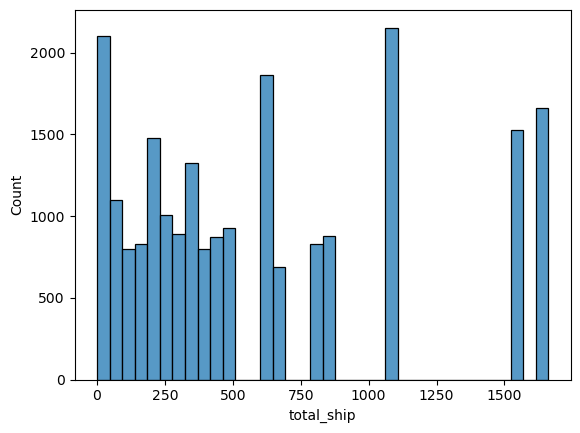

In [28]:
sns.histplot(x=train_data['total_ship']);

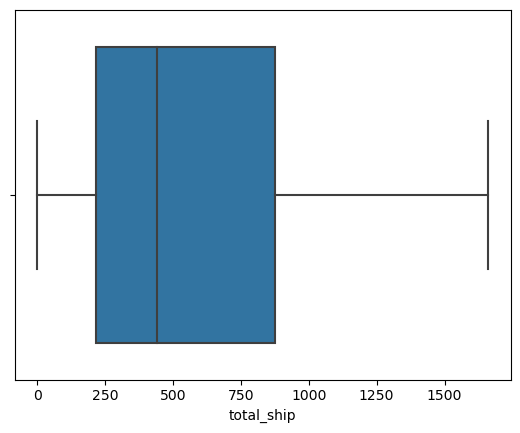

In [29]:
sns.boxplot(x=train_data['total_ship']);

In [30]:
train_data['total_ship'].describe()

count    21742.000000
mean       610.293073
std        514.152519
min          1.000000
25%        216.000000
50%        441.000000
75%        876.000000
max       1661.000000
Name: total_ship, dtype: float64

#### The above and plot and summary explains that the annotation for per image ranges from 1 to 1661.
#### The average annotation for the image is 610.


### Let's extract basic information about the image like width, height, and color mode.

In [31]:
def basic_image_info(path):
    img_id=[]
    img_mode=[]
    img_height=[]
    img_width=[]
    for files in os.listdir(path):
       
        img_id.append(files)
        img=Image.open(f"{(os.path.join(path, files))}")
        img_mode.append(img.mode)
        img_width.append(img.width)
        img_height.append(img.height)


    return pd.DataFrame({'id':img_id,'img_mode':img_mode,'img_width':img_width,'img_height':img_height})
    

In [32]:
train_image_basic_info=basic_image_info("/kaggle/working/ship_detection-huggingface/train/")

In [34]:
train_image_basic_info.head()

id img_mode  img_width  img_height
0    7.jpg      RGB        820        1861
1  120.jpg      RGB       2558        2637
2  200.jpg      RGB       1411         839
3  105.jpg      RGB        714         821
4   74.jpg      RGB        734         562

### Let's see if there are any different color modes in the images.

In [35]:
train_image_basic_info['img_mode'].value_counts()

RGB    256
Name: img_mode, dtype: int64

#### The above information explains that all images are in RGB color mode.

### Let's see the width distribution of the image.

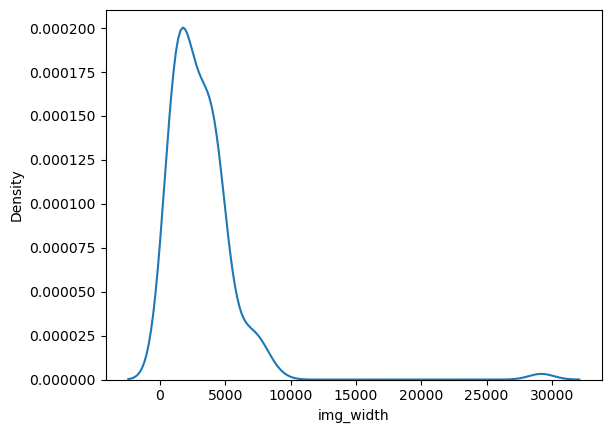

In [36]:
sns.kdeplot(x=train_image_basic_info['img_width']);

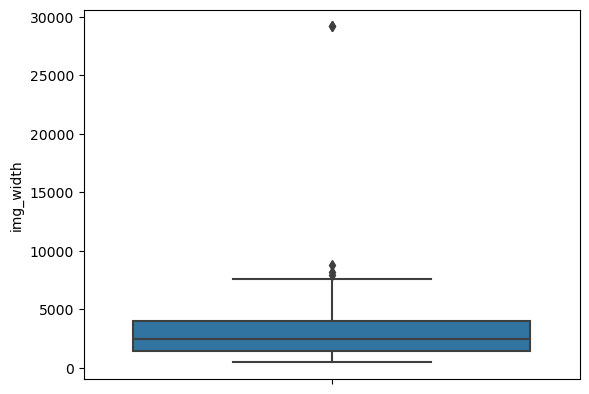

In [37]:
sns.boxplot(y=train_image_basic_info['img_width']);

In [38]:
train_image_basic_info['img_width'].describe()

count      256.000000
mean      3113.738281
std       2929.091389
min        476.000000
25%       1421.500000
50%       2511.000000
75%       4000.000000
max      29200.000000
Name: img_width, dtype: float64

#### The average image width is 3113 pixels.
#### The image width ranges from 476 to 29200 pixels.
#### The boxplot explains that there are images with more than 10000 pixels in width.

### Let's see the height distribution of the image.

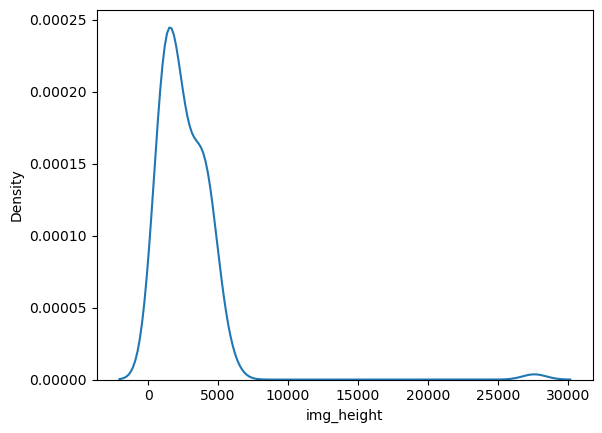

In [39]:
sns.kdeplot(x=train_image_basic_info['img_height']);

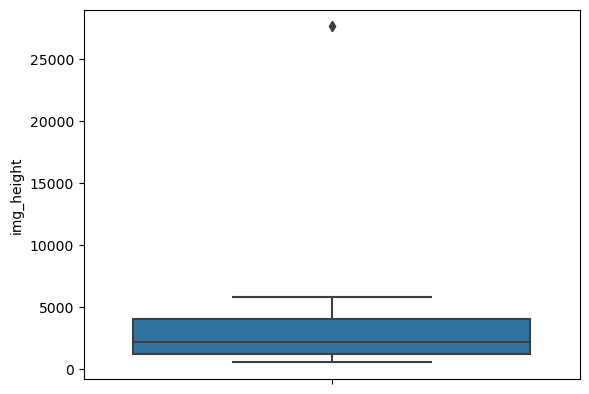

In [40]:
sns.boxplot(y=train_image_basic_info['img_height']);

In [41]:
train_image_basic_info['img_height'].describe()

count      256.000000
mean      2653.066406
std       2599.646032
min        512.000000
25%       1214.500000
50%       2133.500000
75%       4000.000000
max      27620.000000
Name: img_height, dtype: float64

#### The average image height is 2653 pixels.
#### The image height ranges from 512 to 27620 pixels.
#### The boxplot explains that there are images with more than 10000 pixels in height.

### Let's see the RGB color mode distribution of the image by the number of annotations.

In [68]:
def rgb_dist_plot(img,ax):
    start=0
    end=256
    for _,color in enumerate(['Red','Green','Blue']):
        _=sns.kdeplot(img.histogram()[start:end],label=color,color=color)
        _=plt.legend();
        start+=256
        end+=256

#### The annotation for per image ranges from 1 to 1661.So, let's choose ten random total annotation(ship).

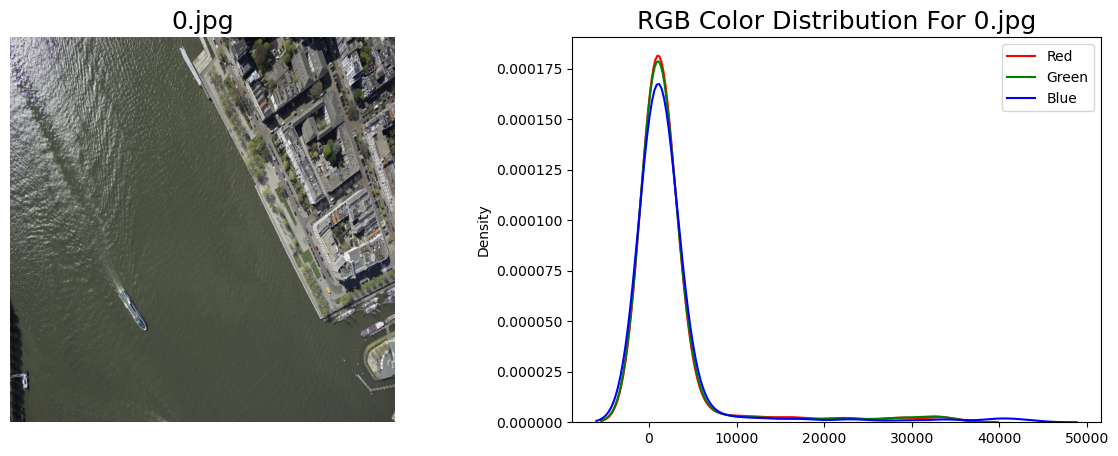

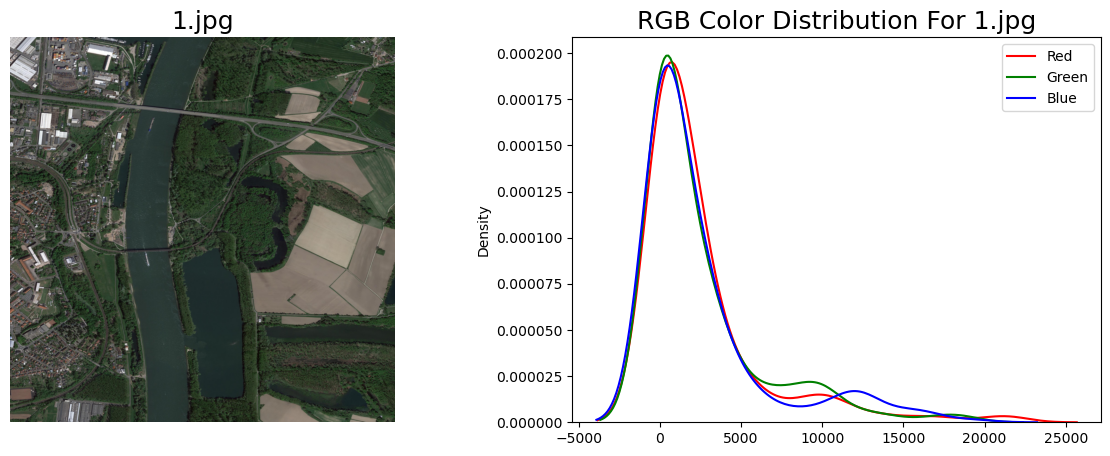

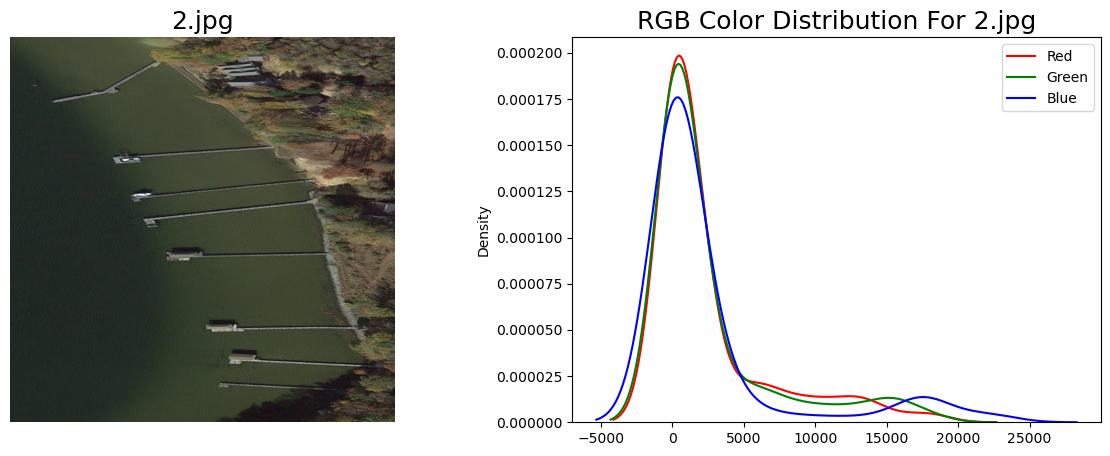

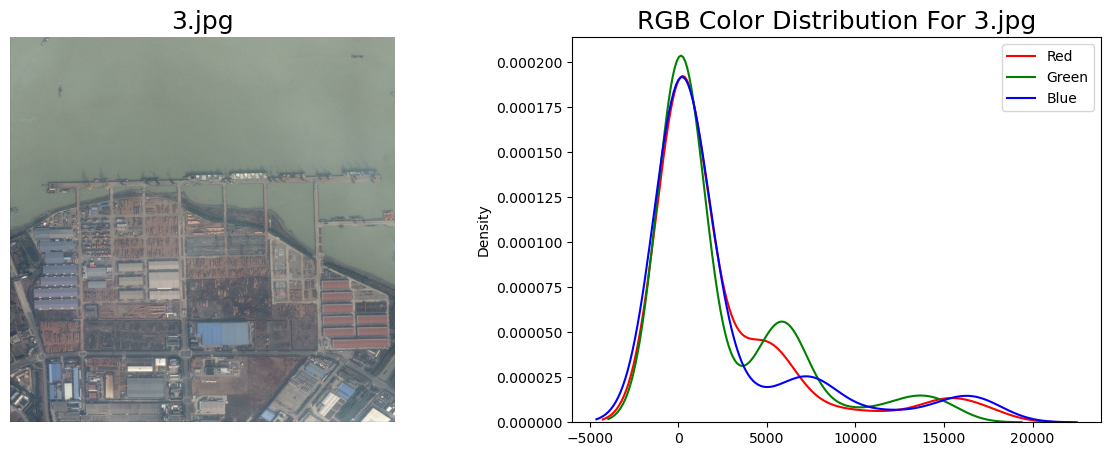

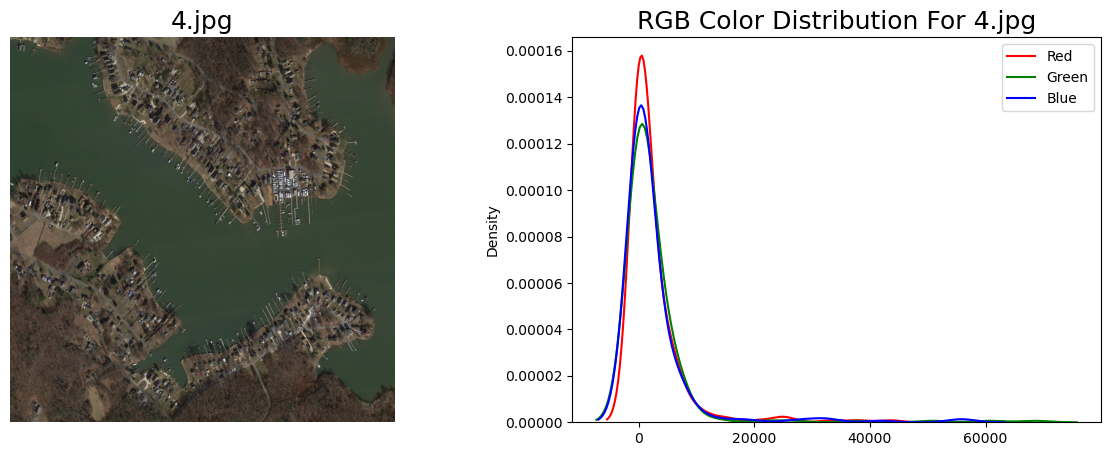

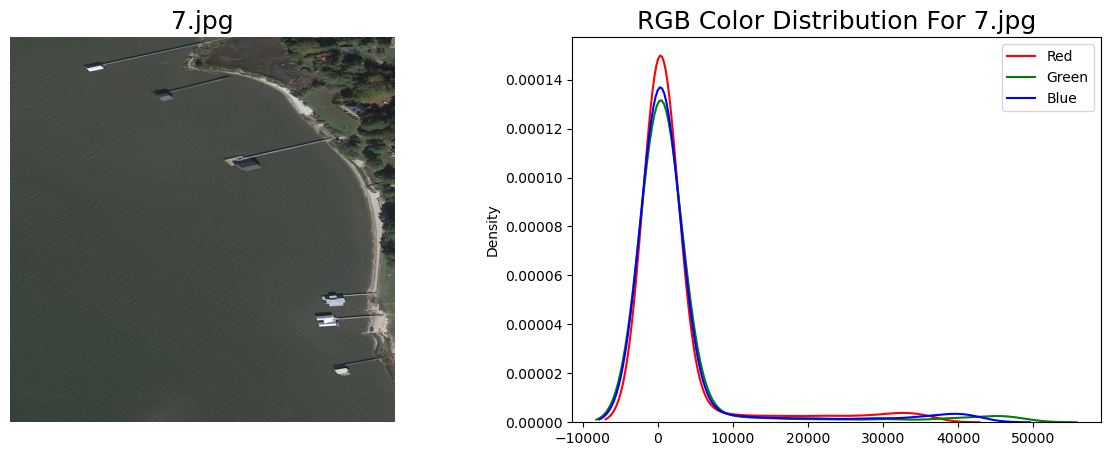

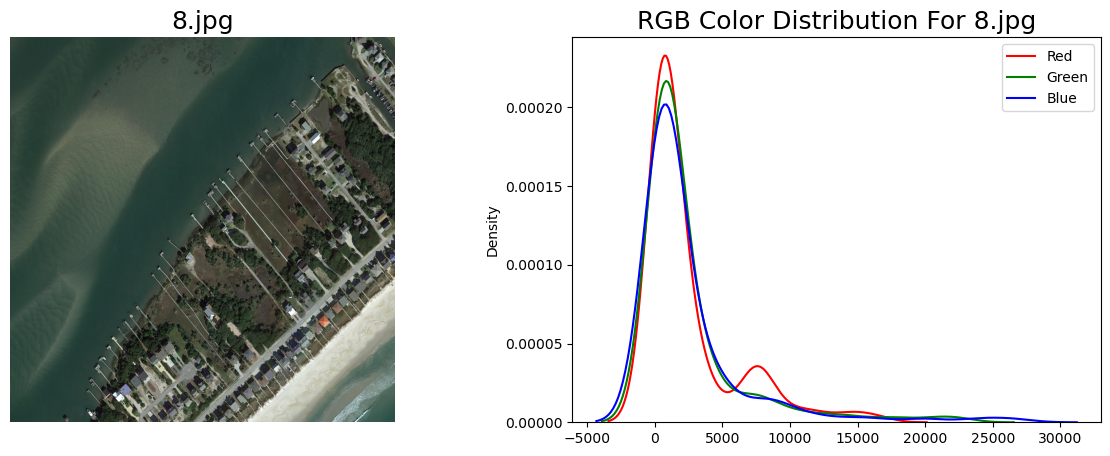

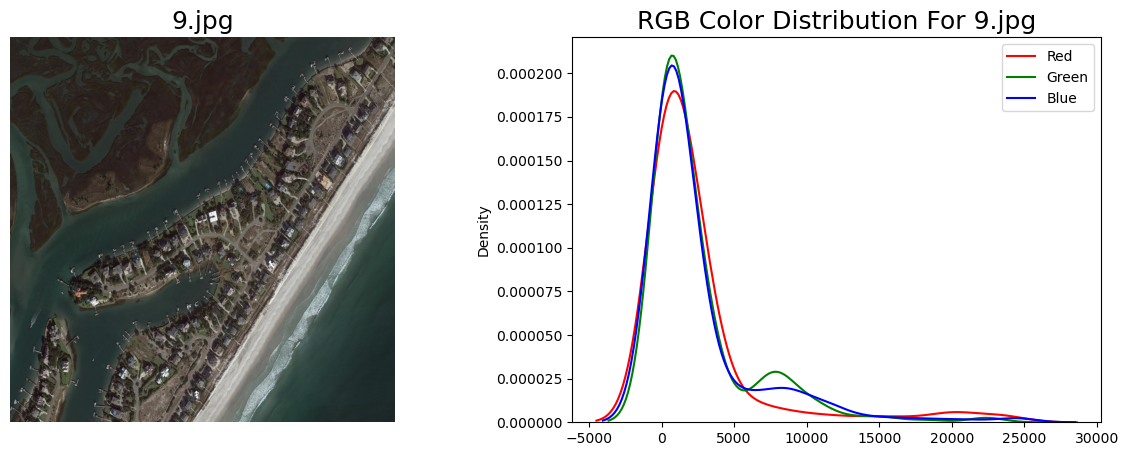

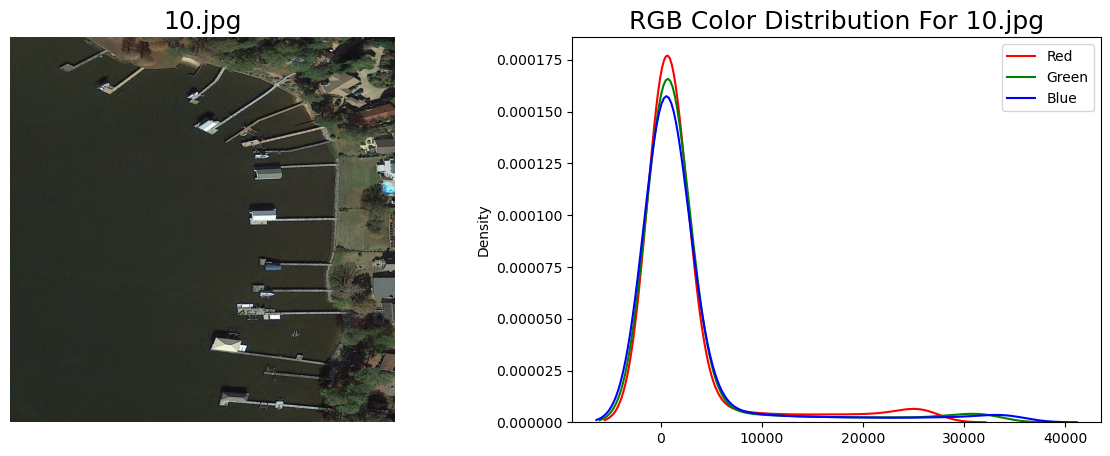

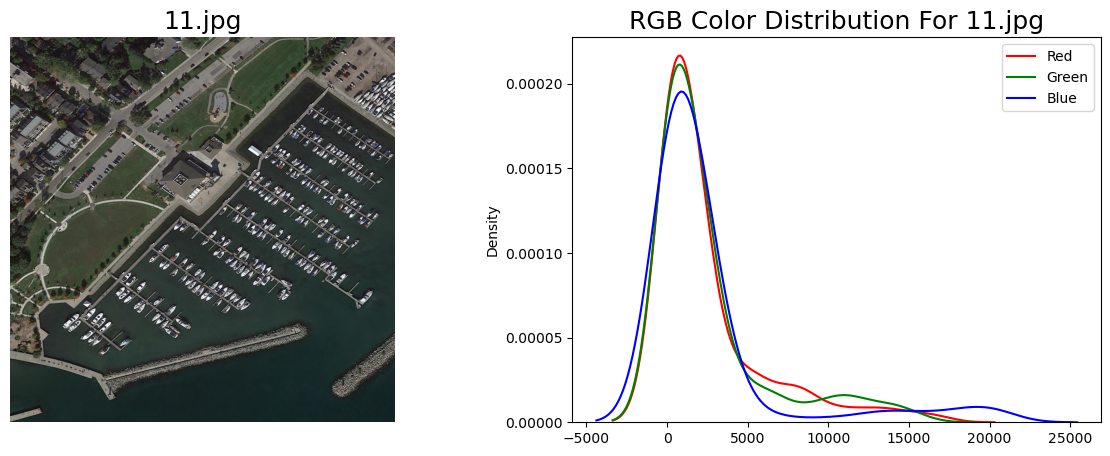

In [116]:
for annot in train_data['total_ship'].unique()[:10]:
    fig, axs = plt.subplots(1, 2 ,figsize=(15,5))
    img_id=train_data[train_data['total_ship']==annot].head(1)['id'].values[0]
    img_file =Image.open(f"/kaggle/working/ship_detection-huggingface/train/{img_id}")
    new_size=800
    img_file=img_file.resize((new_size,new_size))
    axs[0].imshow(img_file)
    axs[0].axis('off')
    axs[0].set_title(img_id,fontsize=18)
    _=rgb_dist_plot(img_file,ax=axs[1])
    axs[1].set_title("RGB Color Distribution For "+img_id,fontsize=18)


#### The above RGB distribution explains that the red and green is the dominant colors in all images.

### Let's calculate area of bounding box(annotated value)

In [90]:
train_data['bbox_area']=train_data.apply(lambda df:((df['xmax']-df['ymin'])*(df['ymax']-df['ymin'])), axis=1)

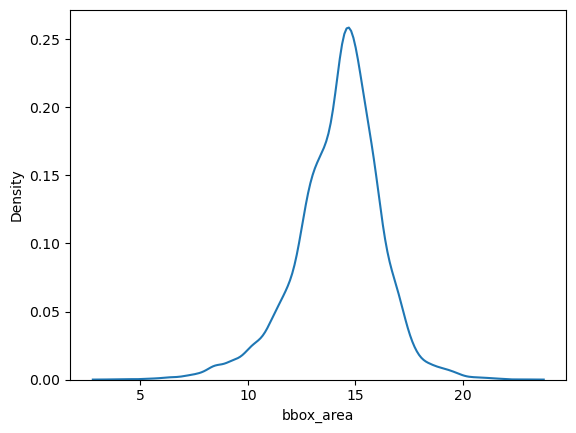

In [94]:
sns.kdeplot(np.log2(train_data['bbox_area']));

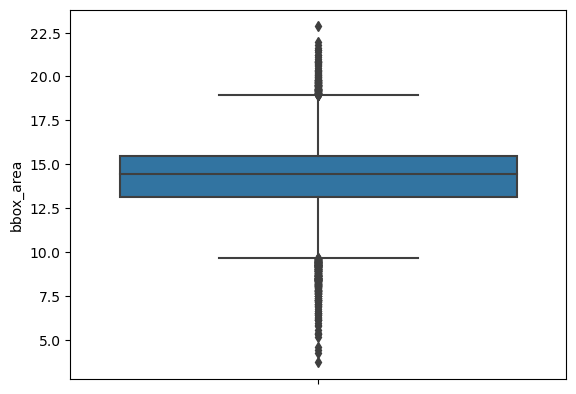

In [97]:
sns.boxplot(y=np.log2(train_data['bbox_area']));

### Let's create a cluster for the bbox_area.

In [98]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

### Create standard scaler and apply to the bbox_area column.

In [99]:
scl=StandardScaler()

### Let's create a kmeans cluster with a range of 2 to 8 number of cluster and select the best one.

In [100]:
iner=[]
for k in range(2,8):
    km=KMeans(n_clusters=k).fit(scl.fit_transform(train_data[['bbox_area']]))
    iner.append(km.inertia_)

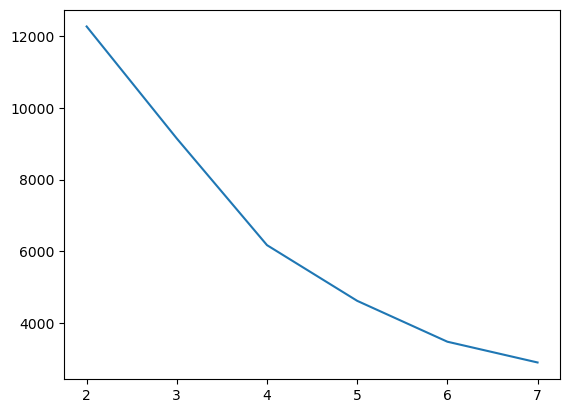

In [101]:
sns.lineplot(x=range(2,8),y=iner);

#### From the above elbow plot the n_cluster 4 is best one. Let's create a kmeans with 4 clusters.

In [102]:
km=KMeans(n_clusters=3).fit(scl.fit_transform(train_data[['bbox_area']]))

### Extract the cluster labels.

In [104]:
train_data['bbox_clus']=km.labels_

### Let's visualize sample images from each clusters.

In [123]:
def bbbox_annotate(img,bbox_df,new_size=False):
    if new_size:
        y_ = img.shape[0]
        x_ = img.shape[1]
        x_scale = new_size / x_
        y_scale = new_size / y_
        img=cv2.resize(img,(new_size,new_size))
        for index, row in bbox_df.iterrows():
            imgs=(cv2.rectangle(img,(int(np.round(row['xmin']*x_scale)),int(np.round(row['ymin']*y_scale))),
                                          (int(np.round(row["xmax"]*x_scale)),int(np.round(row["ymax"]*y_scale))),(255,0,0),5))
        return imgs
    else:
        for index, row in bbox_df.iterrows():
            imgs=(cv2.rectangle(img,(row['xmin'],row['ymin']),
                                          (row["xmax"],row["ymax"]),(255,0,0),5))
        return imgs

In [122]:
def img_read(path,im ,new_size=False):
    img = cv2.imread(f"{(os.path.join(path, im))}")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    if new_size:
        img=cv2.resize(img,(new_size,new_size))
    return img

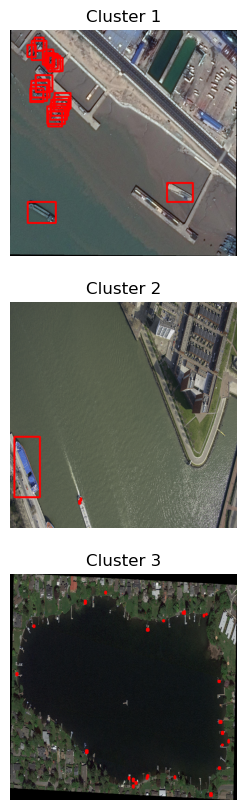

In [130]:
path='/kaggle/working/ship_detection-huggingface/train/'
fig, axs = plt.subplots(3, 1 ,figsize=(8, 10))
i=1
for im,ax in zip(train_data.groupby(['bbox_clus'])['id'].tail(1),axs.flatten()):
    ax.imshow(bbbox_annotate(img_read(path,im),train_data[train_data['id']==im].iloc[:,1:5],800))
    ax.axis('off')
    ax.set_title(f"Cluster {i}")
    i+=1
    

### Let's see sample images by total ship category.

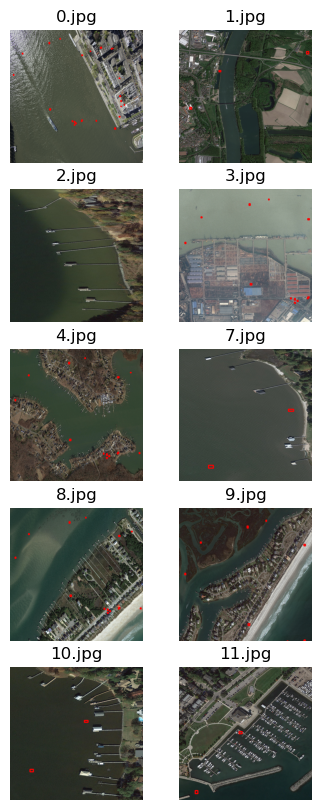

In [136]:

fig, axs = plt.subplots(5, 2 ,figsize=(4, 10))
for i,(annot,ax) in enumerate(zip(train_data['total_ship'].unique()[:10],axs.flatten())):
    img_id=train_data[train_data['total_ship']==annot].head(1)['id'].values[0]
    ax.imshow(bbbox_annotate(img_read(path,img_id),train_data[train_data['id']==im].iloc[:,1:5],800))
    ax.axis('off')
    ax.set_title(f"{img_id}")